In [190]:
# imports
import sys, os
import numpy as np
import pickle, json, csv
import itertools, functools

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update(_VSCode_defaultMatplotlib_Params)

In [103]:
# definitions
def filename2dict(filename, basename=False):
    if basename:
        filename = os.path.basename(filename)
        filename = os.path.splitext(filename)[0]
    if isinstance(filename, str): filename = filename.split('_')
    ans = dict()
    for i,arg in enumerate(filename):
        if '=' in arg:
            k,v = arg.split('=',1)
            ans[k] = v
        else:
            ans[i] = arg
    return ans
    
def extract_args(filename, *keys, join=False):
    if not isinstance(filename, dict): filename = filename2dict(filename)
    ans = {
        k:v
        for k,v in filename.items()
        if k in keys
    }
    if join: ans = '_'.join(f"{v}" if isinstance(k,int) else f"{k}={v}" for k,v in ans.items())
    return ans

def match_args(*filenames, **filename):
    filenames = [
        filename if isinstance(filename, dict) else filename2dict(filename)
        for filename in filenames
    ]+[
        filename
    ]
    for f1,f2 in itertools.permutations(filenames, 2):
        for k,v in f1.items():
            if k in f2 and f2[k] != v: return False
    return True

In [135]:
# define files
logs_dir = "logs2"
train_dir = os.path.join(logs_dir, "train")
eval_dir = os.path.join(logs_dir, "eval")
model_dir = os.path.join(logs_dir, "model")
param_dir = os.path.join(logs_dir, "param")

algos=[]
for path in os.listdir(eval_dir):
    filename = filename2dict(path, basename=True)
    algo = extract_args(filename,
        0,
        'Q',
        # 'obs',
        # 'RM', 'gamma',
        'alpha', 'lambda', 'n',
        'NN_RMenc', 'Aenc',
    join=True)
    if algo not in algos: algos.append(algo)
print("ALGOS:")
for algo in algos: print(algo)

ALGOS:
SarsaLambda_Q=tiles_alpha=0.1
SAC
NStepSarsa_Q=tiles_n=8_alpha=0.05


In [55]:
evalperfs = {}
for path in os.listdir(eval_dir):
    with open(os.path.join(eval_dir, path), 'rb') as f: data = pickle.load(f)
    perf = np.mean([len(trace) for trace in data])
    filename = os.path.splitext(os.path.basename(path))[0]
    evalperfs[filename] = perf

traineps = {}
for path in os.listdir(train_dir):
    with open(os.path.join(train_dir, path), 'rb') as f: data = pickle.load(f)
    eps = len(data)
    filename = os.path.splitext(os.path.basename(path))[0]
    traineps[filename] = eps

In [56]:
# show best runs
n_bests = 15
print("Bests in term of #eval_iterations")
for algo in algos:
    print(f">>> {algo}")
    for run,perf in sorted([
        (run,perf)
        for run,perf in evalperfs.items()
        if match_args(run, algo)
        if perf < 10000 # no timeout
        # if int(filename2dict(run)['seed']) <= 3
    ], key=lambda x: x[1])[:n_bests]:
        print(run, perf)
print()
print("Bests in term of #train_episodes")
for algo in algos:
    print(f">>> {algo}")
    for run,eps in sorted([
        (run,eps)
        for run,eps in traineps.items()
        if match_args(run, algo)
        if eps > 1 # first episode finished
    ], key=lambda x: -x[1])[:n_bests]:
        print(run, eps)

Bests in term of #eval_iterations
>>> NStepSarsa_obs=True_Q=NN
>>> SarsaLambda_obs=True_Q=tiles
SarsaLambda_obs=True_RM=1_gamma=0.99_A=discrete_Q=tiles_lam=0.6_alpha=0.2_seed=2 263.0
SarsaLambda_obs=True_RM=0_gamma=0.99_A=discrete_Q=tiles_lam=0.9_alpha=0.05_seed=1 264.0
SarsaLambda_obs=True_RM=1_gamma=1.0_A=discrete_Q=tiles_lam=0.95_alpha=0.1_seed=1 271.0
SarsaLambda_obs=True_RM=1_gamma=1.0_A=discrete_Q=tiles_lam=0.6_alpha=0.2_seed=1 272.0
SarsaLambda_obs=True_RM=0_gamma=1.0_A=discrete_Q=tiles_lam=0.95_alpha=0.1_seed=1 274.0
SarsaLambda_obs=True_RM=0_gamma=1.0_A=discrete_Q=tiles_lam=0.9_alpha=0.1_seed=2 282.0
SarsaLambda_obs=True_RM=1_gamma=1.0_A=discrete_Q=tiles_lam=0.9_alpha=0.1_seed=1 299.0
SarsaLambda_obs=True_RM=0_gamma=1.0_A=discrete_Q=tiles_lam=0.95_alpha=0.1_seed=2 299.0
SarsaLambda_obs=True_RM=0_gamma=1.0_A=discrete_Q=tiles_lam=0.9_alpha=0.1_seed=1 303.0
SarsaLambda_obs=True_RM=0_gamma=1.0_A=discrete_Q=tiles_lam=0.9_alpha=0.1_seed=3 304.0
SarsaLambda_obs=True_RM=0_gamma=1.0_A=

# Graphs

for each algorithms (fix parameters)
- eval lenght (100 episodes of 1000)
  - mean
  - std
  - median
  - min
  - max

In [62]:
# check that weights vector are not corrupted (overrided)
for path in os.listdir(model_dir):
    path = os.path.join(model_dir, path)
    if not path.endswith('.npy'): continue
    
    data = np.load(path)
    if np.allclose(data, 0): print("CORRUPTED:", path)

In [133]:
# export csv
csv_path = 'log2.csv'

keys = [] # algorithm parameters
for path in os.listdir(eval_dir):
    args = filename2dict(path, basename=True)
    for key in args.keys():
        # if isinstance(key, int): key = ['method'][key]
        if key not in keys: keys.append(key)
with open(csv_path, 'w', newline="") as f:
    csv_writer = csv.writer(f, delimiter='\t')
    title_row = []
    title_row.extend(['method'][k] if isinstance(k, int) else k for k in keys)
    title_row.append("episode")
    title_row.append("episode length")
    title_row.append("done")
    title_row.append("stuck corner")
    csv_writer.writerow(title_row)
    for path in os.listdir(eval_dir):
        path = os.path.join(eval_dir, path)
        args = filename2dict(path, basename=True)

        with open(path, 'rb') as f: data = pickle.load(f)
        if isinstance(data, np.ndarray): # normalize data
            data = [ # split by episode
                data[np.nonzero(data['episode']==episode)]
                for episode in np.unique(data['episode'])
            ]
        
        for ep_data in data:
            row = []
            row.extend(args.get(k, None) for k in keys)
            row.append(ep_data['episode'][0])
            row.append(len(ep_data))
            row.append(int(ep_data[-1]['done']))
            row.append(int(ep_data[-1]['s'][0] >= 0.59))

            csv_writer.writerow(row)
        

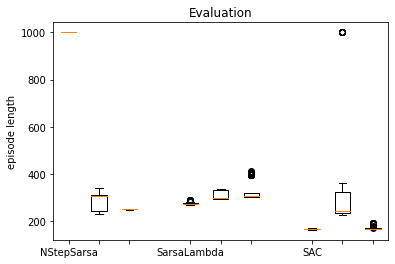

In [195]:
methods = [
    "NStepSarsa_obs=True_RM=0_gamma=1.0_A=discrete_Q=tiles_n=8_alpha=0.05",
    "SarsaLambda_obs=True_RM=0_gamma=1.0_A=discrete_Q=tiles_lam=0.95_alpha=0.1",
    "SAC_obs=True_RM=1_gamma=1.0",
]

x = []
positions=[]
labels = []
p=0
for method in methods:
    label = method.split('_')[0]
    for path in os.listdir(eval_dir):
        path = os.path.join(eval_dir, path)
        args = filename2dict(path, basename=True)
        if not match_args(method, args): continue

        with open(path, 'rb') as f: data = pickle.load(f)
        if isinstance(data, np.ndarray): # normalize data
            data = [ # split by episode
                data[np.nonzero(data['episode']==episode)]
                for episode in np.unique(data['episode'])
            ]

        perfs = [len(trace) for trace in data]

        x.append(perfs)
        positions.append(p)
        labels.append(label)
        p+=1
        label = ""
    p+=1

plt.boxplot(x, positions=positions, labels=labels);
plt.ylabel('episode length')
plt.title("Evaluation")
plt.savefig("plot-eval.png", dpi=240)
None

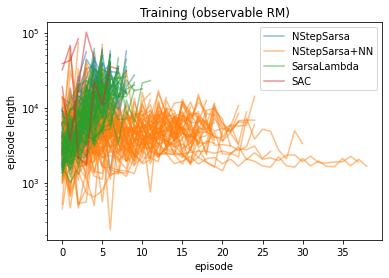

In [203]:
obs = False
methods = [
    f"NStepSarsa_obs={obs}_RM=0_gamma=1.0_A=discrete_Q=tiles_n=8_alpha=0.05",
    f"NStepSarsa_obs={obs}_RM=0_gamma=1.0_A=discrete_Q=NN_RMenc=NNs_Aenc=OneHot_n=8_alpha=0.0001",
    f"SarsaLambda_obs={obs}_RM=0_gamma=1.0_A=discrete_Q=tiles_lam=0.95_alpha=0.1",
    f"SAC_obs={obs}_RM=1_gamma=1.0",
]

x = []
positions=[]
labels = []
p=0
for method in methods:
    label = method.split('_')[0]
    if "Q=NN" in method: label+="+NN"
    color = None
    for dir in ["logs/train", "logsSAC/train"]:
        for path in os.listdir(dir):
            path = os.path.join(dir, path)
            args = filename2dict(path, basename=True)
            if not match_args(method, args): continue

            with open(path, 'rb') as f: data = pickle.load(f)
            if isinstance(data, np.ndarray): # normalize data
                data = [ # split by episode
                    data[np.nonzero(data['episode']==episode)]
                    for episode in np.unique(data['episode'])
                ]

            ep_len = [
                len(trace) for trace in data
                if len(trace) and trace[-1]['done']
            ]
            p, = plt.plot(ep_len, color=color, label=label,
                alpha = 0.5,
                # ls='',
                # marker='o'
            )
            color = p.get_color()

            label = None

plt.title(f"Training ({'non '*(not obs)}observable RM)")
plt.xlabel('episode')
plt.ylabel('episode length')
plt.yscale('log')
plt.legend()
plt.savefig(f"plot-train-obs={obs}.png", dpi=240)
None

# Replay

In [199]:
filename = "logs2/eval/SAC_obs=True_RM=1_gamma=1.0_seed=1.pkl"
video_path = filename.replace('/eval/', '/video/').replace('.pkl', '.gif')
from mountain_car import MountainCarEnvWithStops as MountainCar
from utils import Args, RenderWrapper, GifWrapper
from parameters import set_seed

print("REPLAY")
args = filename2dict(filename, basename=True)
with open(filename, 'rb') as f: data = pickle.load(f)
if isinstance(data, np.ndarray): # normalize data
    data = [ # split by episode
        data[np.nonzero(data['episode']==episode)]
        for episode in np.unique(data['episode'])
    ]

eval_seed = 1
env = MountainCar(observable_RM=(args['obs']=='True'))
env.seed(eval_seed)
set_seed(eval_seed)
env.reset()
gifenv = GifWrapper(env, max_frame=500)
for step in data[0][['s','r','done']]:
    gifenv.step(0, replay=step)
gifenv.save(filename=video_path, fps=120)
env.close()

REPLAY


KeyboardInterrupt: 